In [15]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


def get_features_num_regression(df, target_col, umbral_corr, p_value=None):

    """
    Esta funcion se encarga de comprarar la columna target con el resto y calcular la correlacion, sea igual o mayor al umbral pasado

    Valores:
    df: DataFrame a revisar.
    target_col: Nombre de la columna target. 
    umbral_corr: Umbral de correlación (valor entre 0 y 1).
    p_value (float, opcional): Valor p para test de hipótesis. 

    Devuelve:
    Lista de nombres de columnas numéricas con la correlacion entre ellas.
    """

    #Validaciones. 

    #Validamos que df = un DATAFRAME. Si no arroja error. if not isinstance(df, pd.DataFrame): verifica si df NO es un df de Pandas 

    if not isinstance(df, pd.DataFrame):
        print("Error: df debe ser un valor DataFrame")
        return None

    #Con el is istance validamos que umbral_corr sea un float o integer y despues validamos que este entre 0 y 1. 
    if not isinstance(umbral_corr, (float, int)):
        print("Error: umbral_corr debe ser un número (float o int)")
        return None

    if umbral_corr < 0 or umbral_corr > 1:
        print("Errorr: umbral_corr debe estar entre 0 y 1")
        return None 
    
    #Validamos que se coloque el nombre de la target_col bien
    if target_col not in df.columns:
        print("Error: target_col tiene otro nombre o no esta en este dataframe, verifica los datos")
        return None
    
    #Validamos que sea una columna numerica (en este caso no usamos is instance porque nos dio error en pruebas, ya que al hacer pruebas el tipo de dato era Serie y el is instance no lo tomaba porque buscaba un valor diferente un float)
    if not is_numeric_dtype(df[target_col]):
        print("Error: target_col tiene que ser una columna numerica")
        return None
    
    #P-value inicia como None pero si se llega a pasar su valor debemos comprobar lo mismo. Repetimos el is instance porque es un valor unico y no una serie como arriba
    if p_value is not None:
        if not isinstance(p_value, (float, int)):
            print("Error: p_value tiene que ser un numero")
            return None
        
        #Copiar y pegar comporbacion de umbral corr 
        if p_value < 0 or p_value > 1:
            print("Errorr: p_value tiene que estar entre 0 y 1")
            return None    


    
    # Identificar columnas numéricas
    columnas_numericas = []  # aquí guardaremos solo las columnas que sean numerics

    for columna in df.columns:
        if is_numeric_dtype(df[columna]): #Usamos la misma is_numeric_dtype
            columnas_numericas.append(columna) #La añadimos a nuestra lista vacia 
    
    
   
    #Calcular correlaciones con el target_col que sea superior
    columnas_filtradas = []  # aquí guardaremos las columnas que tienen alta correlación con el target

    for columna in columnas_numericas:
        # Evitamos calcular la correlación de target_col consigo mismo porque dara 1=1
        if columna != target_col:
            correlacion = df[columna].corr(df[target_col])  # usamos .corr() de pandas
           
            # Si la correlación es mayor al umbral, guardamos la columna
            if abs(correlacion) > umbral_corr: #con el abs evitamos que nos de error por que solo nos daba relacion fuerte positiva.
                columnas_filtradas.append(columna)
                
            
                

    # p_value = none, devolvemos ya la lista
    if p_value is None:
        return columnas_filtradas
    
    # si p_value = valor entre 0 y 1, mediremos que tan probable es que haya ocurrido el evento por csualidad con pearson

    columnas_significativas = []
    #Recorremos las columnas que yapasaron el filtro de correlaciony eliminamos las que tengan nulos
    for columna in columnas_filtradas:
        datos = df[[columna, target_col]].dropna()
        if len(datos) < 3:
            print(f"Error: No se puede aplicar Pearson en '{columna}' por pocos datos.")
            continue
        r, p = pearsonr(datos[columna], datos[target_col])
        if p <= (1 - p_value):
            columnas_significativas.append(columna)
            

    return columnas_significativas 

def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    #hacemos una llamda a la funcion get_features_num_regression para obtener las columnas significativas y se hagan las comprobaciones necesarias
    columnas_significativas = get_features_num_regression(df = df, target_col = target_col, umbral_corr = umbral_corr, p_value= pvalue)
    # Si columns es igual a cero utilizamos todas las columnas del dataframe 
    if len(columns) == 0:
        columns = df.columns[:]
    
    # Hacemos una intersección entre las columnas del dataframe y las columnas significativas
    columnas_validadas = [col for col in columns if col in columnas_significativas]
    #En caso de no haber columnas validas, mostramos un mensaje y salimos de la funcion
    if not columnas_validadas:
        print("No hay columnas que cumplan con los criterios de correlación y p-value.")
        return
    else:
        ini = 0
        # Utilizamos un bucle para que grafique de 5 en 5
        while ini <= len(columnas_validadas):
            columnas_validadas1 = columnas_validadas[ini:ini+5]
            sns.pairplot(df, x_vars=columnas_validadas1, y_vars=[target_col])
            plt.suptitle(f"Gráficos de dispersión para {target_col} y columnas significativas", y=1.04)
            plt.show()
            ini += 5

In [3]:
df_example = pd.read_csv("data/advertising_ml.csv")
df_example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   object 
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 78.3+ KB


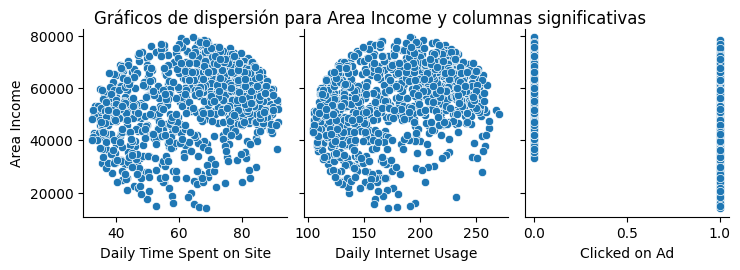

In [16]:
plot_features_num_regression(df_example, target_col="Area Income", umbral_corr=0.1, pvalue=0.05)